In [90]:
import numpy as np
import pandas as pd
import os

#import stuff and define functions
from typing import Dict, List, Optional, Union
from pathlib import Path
from sklearn.decomposition import IncrementalPCA, PCA
from CustomFunctions import shapePCAtools
import math
from vtk.util import numpy_support
import vtk
from aicsshparam import shtools
import pickle as pk
def angle360(x,y):
    return abs(math.degrees(np.arctan2(y,x))) if y < 0 else abs(math.degrees(np.arctan2(y,x))-360)

In [11]:
############# gather data from all experiments ###############
folders = ['Galvanotaxis_iSIM',
           'Chemotaxis_iSIM']
lst = []
for f in folders:
    tempfl = f'E:/Aaron/{f}/Data_and_Figs/'
    df = pd.read_csv(tempfl + 'Shape_Metrics_outliersremoved.csv', index_col='cell')
    lst.append(df)
df = pd.concat(lst)

In [12]:
######### Perform PCA and divide cells into shape space bins ################


savedir = 'E:/Aaron/Combined_iSIM_PCA/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
lmax = 10


#get coeffs only
coeff_df = df[[x for x in df.columns.to_list() if 'shcoeffs' in x]]


# Fit and transform the data
pca = PCA(n_components=npcs)
pca = pca.fit(coeff_df)
matrix_of_features_transform = pca.transform(coeff_df)


# Dataframe of transformed variable
pc_names = [f"PC{c}" for c in range(1, 1 + npcs)]
df_trans = pd.DataFrame(data=matrix_of_features_transform, columns=pc_names, index = coeff_df.index)


# Adjust the sign of PCs so that larger cells are represent by positive values
#need actual volume data to do this so needs to be combined with shape metrics
df_trans['Cell_Volume'] = df.Cell_Volume
for pcid, pc_name in enumerate(pc_names):
    pearson = np.corrcoef(df_trans.Cell_Volume.values, df_trans[pc_name].values)
    if pearson[0, 1] < 0:
        df_trans[pc_name] *= -1
        pca.components_[pcid] *= -1

df_trans = df_trans.drop(columns = 'Cell_Volume')



################ RECONSTRUCT CELLS AT CERTAIN POINTS IN THE "SHAPE SPACE" ##################

df_dig = pd.DataFrame(index = df_trans.index)
for count, col in enumerate(df_trans.columns.to_list()):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = df_trans,
        feature = col,
        nbins = nbins,
        filter_based_on = df_trans.columns.to_list(),
        filter_extremes_pct = float(1),
        save = None,
        return_freqs_per_structs = False
    )
    #put bin_indexes into a larger list that I can later iterate through
    df_dig = df_dig.merge(df_digit[[col,'bin']], left_index = True, right_index = True)
    df_dig = df_dig.rename(columns={'bin':f'PC{count+1}_bins'})

    
mid = math.ceil(nbins/2)
recon_PCs = np.zeros((npcs, nbins, npcs))
for pi, p in enumerate(pc_names):
    for c in range(nbins):
        for ni, n in enumerate(pc_names):
            if n == p:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==c+1].loc[:,n].mean()
            else:
                recon_PCs[pi,c,ni] = df_dig[df_dig[f'PC{ni+1}_bins']==mid].loc[:,n].mean()

#get inverse pca transform of those values
recon_schoeffs = np.zeros((npcs, nbins, len(coeff_df.columns)))
for o in range(recon_schoeffs.shape[0]):
    for t in range(recon_schoeffs.shape[1]):
            recon_schoeffs[o,t,:] = pca.inverse_transform(recon_PCs[o,t,:])
            
    
#combine metrics and digitized pcs
df_dig = df.merge(df_dig, left_index = True, right_index = True)
#save the digitized PCs for the shape space
df_dig.to_csv(savedir+"Shape_Metrics_with_Digitized_PCs.csv")
#save just the PCs with the other cell data, no digitized PCs
digless = df_dig.drop(columns=[x for x in df_dig.columns.to_list() if 'shcoeff' in x or 'bin' in x or '.1' in x]).reset_index()
digless.to_csv(savedir+"Shape_Metrics_with_PCs.csv")

########### GET RECONSTRUCTIONS OF AVERAGE CELLS FROM SHAPE SPACE BINS ##########################

meshes = {}
aliases = ['Cell']

for pi, p in enumerate(pc_names):
    meshes[p] = {}
    for c in range(nbins):
        meshes[p][bins[c]] = {}
        row = pd.Series(recon_schoeffs[pi,c,:], index = coeff_df.columns.to_list())
        for i, a in enumerate(aliases):
            mesh, _ = shtools.get_reconstruction_from_coeffs(recon_schoeffs[pi,c,:].reshape(2,lmax+1,lmax+1))
            meshes[p][bins[c]][a] = mesh

                
                
################## save PC meshes ##################
pcmeshdir = savedir + 'PC_Meshes/'
if not os.path.exists(pcmeshdir):
    os.makedirs(pcmeshdir)
for p in list(meshes):
    for n, b in enumerate(list(meshes[p])):
        for a in list(meshes[p][b]):
            writer = vtk.vtkXMLPolyDataWriter()
            writer.SetFileName(pcmeshdir+p+'_'+str(b)+'_'+a+'.vtp')
            writer.SetInputData(meshes[p][b][a])
            writer.Write()

####### also save the pca object for later use ###########
pk.dump(pca, open(savedir+"pca.pkl","wb"))



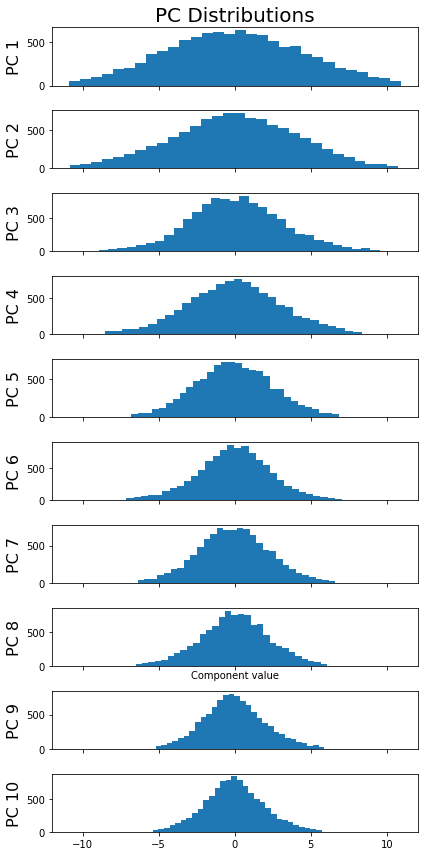

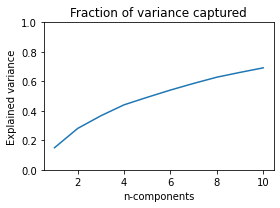

In [13]:
##################### PCA relevant figures #######################


########### plot distributions of PCs ###################
import matplotlib.pyplot as plt
fig, axes = plt.subplots(10, 1, figsize=(6,12), sharex=True)
for i, ax in enumerate(axes[:]):
    ax.hist(digless[pc_names].iloc[:,i].values, 30)
# for i, ax in enumerate(axes[:,1]):
#     ax.hist(nuc_weights[:,i], 30, (-2,2))
    
axes[0].set_title("PC Distributions", fontsize = 20)
# axes[0,1].set_title("Nucleus Distributions", fontsize = 20)
[ax.set_ylabel("PC %i"%(i+1), fontsize = 16) for i, ax in enumerate(axes[:])];
axes[7].set_xlabel("Component value")

plt.tight_layout()
plt.savefig(savedir+ 'PC distributions.png', bbox_inches='tight')



# How much variance is explained?
cell_variance = np.cumsum(pca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Analysis of explained variance
df_dimred = {}
loading = pca.components_.T * np.sqrt(pca.explained_variance_)
for comp, pc_name in enumerate(pc_names):
    load = loading[:, comp]
    pc = [v for v in load]
    apc = [v for v in np.abs(load)]
    total = np.sum(apc)
    cpc = [100 * v / total for v in apc]
    df_dimred[pc_name] = pc
    df_dimred[pc_name.replace("_PC", "_aPC")] = apc
    df_dimred[pc_name.replace("_PC", "_cPC")] = cpc

# Store results as a dataframe
df_dimred["features"] = coeff_df.columns
df_dimred = pd.DataFrame(df_dimred)
df_dimred = df_dimred.set_index("features", drop=True)

# Plot variance
plt.figure(figsize=(4, 3))
plt.plot(component_number, cell_variance)
plt.ylim(0,1)
plt.xlabel("n-components")
plt.ylabel("Explained variance")
plt.title("Fraction of variance captured")

plt.tight_layout()
plt.savefig(savedir + 'Variance captured.png', bbox_inches='tight')



# ######## OR A DIFFERENT PLOT ##############
# # Make plot of explained variance
# plt.plot(100 * pca.explained_variance_ratio_[:npcs_to_calc], "-o")
# title = "Cum. variance: (1+2) = {0}%, Total = {1}%".format(
#     int(100 * pca.explained_variance_ratio_[:2].sum()),
#     int(100 * pca.explained_variance_ratio_[:].sum()),
# )
# plt.xlabel("Component", fontsize=18)
# plt.ylabel("Explained variance (%)", fontsize=18)
# plt.xticks(
#     ticks=np.arange(npcs_to_calc),
#     labels=np.arange(1, 1 + npcs_to_calc),
#     fontsize=14,
# )
# plt.yticks(fontsize=14)
# plt.title(title, fontsize=18)
# plt.tight_layout()



############## SEE WHICH FEATURES ARE MOST IMPORTANT IN EACH PC #############
save = savedir + 'Feature_Importance'
# Log feature importance along each PC
with open(f"{save}.txt", "w") as flog:

    for comp in range(npcs):

        print(
            f"\nExamplined variance by PC{comp+1} = {100*pca.explained_variance_ratio_[comp]:.1f}%",
            file=flog,
        )

        # Feature importance is reported in 3 ways:
        # _PC - raw loading
        # _aPC - absolute loading
        # _cPC - normalized cummulative loading
        pc_name = pc_names[comp]
        df_sorted = df_dimred.sort_values(
            by=[pc_name.replace("_PC", "_aPC")], ascending=False
        )
        pca_cum_contrib = np.cumsum(
            df_sorted[pc_name.replace("_PC", "_aPC")].values
            / df_sorted[pc_name.replace("_PC", "_aPC")].sum()
        )
        pca_cum_thresh = np.abs(pca_cum_contrib - 0.80).argmin()
        df_sorted = df_sorted.head(n=pca_cum_thresh + 1)

        print(
            df_sorted[
                [
                    pc_name,
                    pc_name.replace("_PC", "_aPC"),
                    pc_name.replace("_PC", "_cPC"),
                ]
            ].head(),
            file=flog,
        )

In [15]:
############# CALCULATE A BUNCH OF METRICS ###################
from scipy.spatial import ConvexHull
#get directories and open separated datasets
from itertools import groupby
from operator import itemgetter
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A


savedir = 'E:/Aaron/Combined_iSIM_PCA/'

nbins = 11


#get directories
TotalFrame = pd.read_csv(savedir + 'Shape_Metrics_with_PCs.csv', index_col = 0)

#remove the "Cell_" from PCs
for x in TotalFrame.columns.to_list():
    if 'PC' in x:
        TotalFrame = TotalFrame.rename(columns = {x:x.replace('Cell_','')})
#add a column that identifies cells across all frames
TotalFrame['CellID'] = [x.split('_frame')[0] for x in TotalFrame.cell.to_list()]

#Add Elongation metric
TotalFrame['Cell_Elongation'] = TotalFrame['Cell_MajorAxis']/TotalFrame['Cell_MinorAxis']

#Add Volume Ratios
TotalFrame['Volume_Front_Ratio'] = TotalFrame.Cell_Volume_Front/TotalFrame.Cell_Volume
TotalFrame['Volume_Right_Ratio'] = TotalFrame.Cell_Volume_Right/TotalFrame.Cell_Volume
TotalFrame['Volume_Top_Ratio'] = TotalFrame.Cell_Volume_Top/TotalFrame.Cell_Volume


#sphericity calculation (ratio of surface area of circle with same volume to actual surface area)
Cell_Sphere = []
for index, row in TotalFrame.iterrows():
    #cell sphericity
    r = ((3*row.Cell_Volume)/(4*math.pi)) ** (1/3)
    SA = 4*math.pi*r
    Cell_Sphere.append(SA/row.Cell_SurfaceArea)
TotalFrame['Cell_Sphericity'] = Cell_Sphere


######### Get angles of long axes relative to the axis of trajectory #############
RelativeAngles = pd.DataFrame()
vectors = sorted([i for i in row.index if 'MajorAxis_Vec' in i])
# row = RandomRotations.iloc[0]
for index, row in TotalFrame.iterrows():
    angles = {}
    arr = row[vectors].to_numpy()
    if arr[0] < 0:
        arr = arr*-1
    #get angle between the vector and the planes
    UpDownAngle = distance(arr[0], arr[1], arr[2], arr[0], arr[1], 0)
    LeftRightAngle = distance(arr[0], arr[1], arr[2], arr[0], 0, arr[2])
    TotalAngle = distance(arr[0], arr[1], arr[2], 1, 0, 0)
    #append angles
    rx = vectors[0].split('_')[0]
    angles[rx +'_UpDownAngle'] = UpDownAngle if arr[2]>0 else -1*UpDownAngle
    angles[rx +'_LeftRightAngle'] = LeftRightAngle if arr[1]>0 else -1*LeftRightAngle
    angles[rx +'_TotalAngle'] = TotalAngle
    RelativeAngles = RelativeAngles.append(angles, ignore_index=True)
#add the angles to the dataframe and remove vectors
TotalFrame = TotalFrame.merge(RelativeAngles, left_index = True, right_index = True)

pclist = [x for x in TotalFrame.columns.to_list() if 'PC' in x]
centers = []
for count, col in enumerate(pclist):
    df_digit, bin_indexes, (bin_centers, pc_std) = shapePCAtools.digitize_shape_mode(
        df = TotalFrame,
        feature = col,
        nbins = nbins,
        filter_based_on = pclist,
        filter_extremes_pct = 0,
        save = None,
        return_freqs_per_structs = False,
    )
    #put bin_indexes into a larger list that I can later iterate through
    TotalFrame[f'PC{count+1}bins'] = df_digit.bin
    #get bin centers for each PC
    centers.append(pd.Series(bin_centers*pc_std, name=col))
centers = pd.DataFrame(centers).T
centers.to_csv(savedir+'PC_bin_centers.csv')


################ add all of the different classifiers to the dataset
galvdates = ['20230727','20230801','20230802','20230803']
chemdates = ['20230509','20230510','20230511','20230524','20230525']
treat = []
experiment = []
temp = []
exno = []
date = []

for f, m in zip(TotalFrame['cell'].to_list(), TotalFrame['frame'].to_list()):
    if any([x in f for x in galvdates]):
        experiment.append('Galvanotaxis')
        if 'Galv' in f:
            treat.append('Galv_Directed')
        elif 'Random' in f:
            treat.append('Random')
    elif any([x in f for x in chemdates]):
        experiment.append('Chemotaxis')
        if m<41:
            treat.append('Random')
        else:
            treat.append('Chem_Directed')
    
    #get the date and experiment number on that date
    spl = f.split('_')
    date.append(spl[0])
    exno.append(spl[spl.index('cell')-1])
    temp.append('37C')
    
    
TotalFrame['Date'] = date
TotalFrame['Experiment_Number'] = exno
TotalFrame['Treatment'] = treat
TotalFrame['Experiment'] = experiment
TotalFrame['Temperature'] = temp


# ############ calculate the distance travelled between time points in the PC1-PC2 CGPS ##########
# to = []
# fromm = []
# idd = []
# ae = []
# for i, cells in TotalFrame.sort_values('frame').groupby('CellID'):
#     runs = list()
#     #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
#     for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
#         currentrun = list(map(itemgetter(1), g))
#         list.append(runs, currentrun)

#     for r in runs:
#         r = np.array(r, dtype=int)
#         cell = cells[cells.frame.isin(r)]
#         tdiffs = cell[['PC1bins','PC2bins']].diff()
#         fdiffs = cell[['PC1bins','PC2bins']].diff(-1)
#         PC1_PC2_distance_to = []
#         PC1_PC2_distance_from = []
#         points = []
#         area_explored = []
#         for d in range(len(cell)):
#             #calculate the change distance the cell HAS travelled
#             PC1_PC2_distance_to.append(np.sqrt(tdiffs.iloc[d].PC1bins**2 + tdiffs.iloc[d].PC2bins**2))
#             #calculate the change distance the cell WILL travel
#             PC1_PC2_distance_from.append(np.sqrt(fdiffs.iloc[d].PC1bins**2 + fdiffs.iloc[d].PC2bins**2))
#             #points explored
#             points.append(cell.iloc[d][['PC1bins','PC2bins']].to_list())
#             #calculate convex hull at this time point
#             try:
#                 area_explored.append(ConvexHull(points).area)
#             except:
#                 area_explored.append(0)
#         to.extend(PC1_PC2_distance_to)
#         fromm.extend(PC1_PC2_distance_from)
#         idd.extend(cell.cell.to_list())
#         ae.extend(area_explored)
# #add them to the the total dataframe
# TotalFrame = TotalFrame.merge(pd.DataFrame({'cell':idd,
#               'PC1_PC2_distance_to':to,
#               'PC1_PC2_distance_from':fromm,
#                 'PC1_PC2_cumulative_area_explored':ae}),
#               left_on = ['cell'],
#             right_on = ['cell'])

TotalFrame.to_csv(savedir + 'Shape_Metrics_transitionPCbins.csv')
print('Calculated combined PCs and binned PCs')

Calculated combined PCs and binned PCs


In [72]:
pcdf = df[[x for x in df.columns.to_list() if 'bins' in x]]
for g in df.structure.unique():
    for i, p in enumerate(pcdf.columns.to_list()):
        for b in bins:
            allpilrs = []
            ######### do the averaging for each migration mode ########
            for m in df.Treatment.unique():
                temp = pcdf[p][(df.structure==g) & (df.Treatment==m)]
                num = temp[temp==b].index.to_list()
                exps = df[df.index.isin(num)].Experiment
                pilrfi = [chempilrs + n[0] + '_PILR.tiff' if n[1] == 'Chemotaxis' else galvpilrs + n[0] + '_PILR.tiff' for n in exps.items()]
                print(len(pilrfi))

In [74]:
allpilrfiles[0]

'20230509_488EGFP-CAAX_640SPY650-DNA1_cell_0_frame_21_PILR.tiff'

In [85]:
############## Average PILRs of entire dataset and split by migration mode #########################
import multiprocessing
from CustomFunctions import PILRagg
from aicscytoparam import cytoparam
import re
import vtk
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

folder_fl = 'E:/Aaron/Combined_iSIM_PCA/'
pilr_fl = folder_fl + 'Processed_Data/PILRs/'
chempilrs = 'E:/Aaron/Chemotaxis_iSIM/Processed_Data/PILRs/'
galvpilrs = 'E:/Aaron/Galvanotaxis_iSIM/Processed_Data/PILRs/'
#get the names of all the existing pilrs
chemfiles = [x for x in os.listdir(chempilrs)]
galvfiles = [x for x in os.listdir(galvpilrs)]
allpilrfiles = [x.split('_PILR.tiff')[0] for x in chemfiles + galvfiles]
pilragg_fl = folder_fl + 'Processed_Data/avgPILRs/'
if not os.path.exists(pilragg_fl):
    os.makedirs(pilragg_fl)
    
#specify number of PCs and number of bins
npcs = 10
nbins = 5
bins = list(range(1,nbins+1))
nisos = [1,63]
lmax = 10

#make tiny sphere for inner mesh
#create inner sphere
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(0.0, 0.0, 0.0)
sphereSource.SetRadius(nisos[0]/2)
# Make the surface smooth.
sphereSource.SetPhiResolution(100)
sphereSource.SetThetaResolution(100)
sphereSource.Update()
spherepoly = sphereSource.GetOutput()


#open dataframe with digitized PCs and get the condition info
df = pd.read_csv(folder_fl + 'Shape_Metrics_with_Digitized_PCs.csv', index_col = 'cell')
condf = pd.read_csv(folder_fl + 'Shape_Metrics_transitionPCbins.csv', index_col = 'cell')
conlist = ['Date','Experiment_Number','Treatment','Experiment','Temperature']
df = df.merge(condf[conlist], left_index = True, right_index = True)
#limit names to only the ones of measured pilrs
df = df[df.index.isin(allpilrfiles)]

pcdf = df[[x for x in df.columns.to_list() if 'bins' in x]]
for g in df.structure.unique():
    for i, p in enumerate(pcdf.columns.to_list()):
        for b in bins:
            allpilrs = []
            ######### do the averaging for each migration mode ########
            for m in df.Treatment.unique():
                temp = pcdf[p][(df.structure==g) & (df.Treatment==m)]
                num = temp[temp==b].index.to_list()
                exps = df[df.index.isin(num)].Experiment
                pilrfi = [chempilrs + n[0] + '_PILR.tiff' if n[1] == 'Chemotaxis' else galvpilrs + n[0] + '_PILR.tiff' for n in exps.items()]
                if len(pilrfi) == 0:
                    continue
                else:
                    if __name__ ==  '__main__':
                        # use multiprocessing to read all of the pilr files
                        pool = multiprocessing.Pool(processes=60)
                        pilrlist = pool.map(PILRagg.read_parameterized_intensity, pilrfi)
                        pool.close()
                        pool.join()
                pagg = np.array(pilrlist)
                allpilrs.append(pagg)
                del pilrlist
                #get average representation
                pagg_avg = np.mean(pagg, axis = 0)
                #normalize representations
                pagg_norm = PILRagg.normalize_representations(pagg)
                pagg_norm_avg = np.mean(pagg_norm, axis = 0)
                dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
                dims = ''.join(dims[::-1])
                OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg.tif', dim_order=dims)
                OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg_norm.tif', dim_order=dims)


                mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
                domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
                coords_param, _ = cytoparam.parameterize_image_coordinates(
                    seg_mem=(domain>0).astype(np.uint8),
                    seg_nuc=(domain>1).astype(np.uint8),
                    lmax=lmax,
                    nisos=nisos
                )

                morphed = cytoparam.morph_representation_on_shape(
                            img=domain,
                            param_img_coords=coords_param,
                            representation=pagg_avg)
                morphed = np.stack([domain, morphed])
                OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_aggmorph.tif', dim_order='CZYX')
            ####### do all the averaging for the TOTAL data 
            pagg = np.concatenate(allpilrs)
            #get average representation
            pagg_avg = np.mean(pagg, axis = 0)
            #normalize representations
            pagg_norm = PILRagg.normalize_representations(pagg)
            pagg_norm_avg = np.mean(pagg_norm, axis = 0)
            dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
            dims = ''.join(dims[::-1])
            OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_repsagg.tif', dim_order=dims)
            OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_repsagg_norm.tif', dim_order=dims)


            mesh_outer = PILRagg.read_vtk_polydata(folder_fl+'PC_Meshes/'+f'Cell_PC{i+1}_{b}_Cell.vtp')
            domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
            coords_param, _ = cytoparam.parameterize_image_coordinates(
                seg_mem=(domain>0).astype(np.uint8),
                seg_nuc=(domain>1).astype(np.uint8),
                lmax=lmax,
                nisos=nisos
            )

            morphed = cytoparam.morph_representation_on_shape(
                        img=domain,
                        param_img_coords=coords_param,
                        representation=pagg_avg)
            morphed = np.stack([domain, morphed])
            OmeTiffWriter.save(morphed, pilragg_fl+p[:-1]+str(b)+f'_alldata_{g}_aggmorph.tif', dim_order='CZYX')

            print(f'Done with {g} {p} bin {b}')

Done with myosin PC1_bins bin 1
Done with myosin PC1_bins bin 2
Done with myosin PC1_bins bin 3
Done with myosin PC1_bins bin 4
Done with myosin PC1_bins bin 5
Done with myosin PC2_bins bin 1
Done with myosin PC2_bins bin 2
Done with myosin PC2_bins bin 3
Done with myosin PC2_bins bin 4
Done with myosin PC2_bins bin 5
Done with myosin PC3_bins bin 1
Done with myosin PC3_bins bin 2
Done with myosin PC3_bins bin 3
Done with myosin PC3_bins bin 4
Done with myosin PC3_bins bin 5
Done with myosin PC4_bins bin 1
Done with myosin PC4_bins bin 2
Done with myosin PC4_bins bin 3
Done with myosin PC4_bins bin 4
Done with myosin PC4_bins bin 5
Done with myosin PC5_bins bin 1
Done with myosin PC5_bins bin 2
Done with myosin PC5_bins bin 3
Done with myosin PC5_bins bin 4
Done with myosin PC5_bins bin 5
Done with myosin PC6_bins bin 1
Done with myosin PC6_bins bin 2
Done with myosin PC6_bins bin 3
Done with myosin PC6_bins bin 4
Done with myosin PC6_bins bin 5
Done with myosin PC7_bins bin 1
Done wit

In [91]:
############## get 1D cycle for PC dynamics WITHOUT USING BINS ##############
orig = [5, 6]
whichpcs = [1,8]


### get centered PC bins first
x = TotalFrame[f'PC{whichpcs[0]}'].values-centers[f'PC{whichpcs[0]}'].iloc[orig[0]-1]
y = TotalFrame[f'PC{whichpcs[1]}'].values-centers[f'PC{whichpcs[1]}'].iloc[orig[1]-1]
### calculate angular coord and radius
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord'] = [angle360(x1, y1) for x1, y1 in zip(x, y)]
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Radial_Coord'] = np.sqrt((x**2) + (y**2))
### "bin" the Angular coord
TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Bins'] = [math.ceil(i) for i in TotalFrame[f'PC{whichpcs[0]}_PC{whichpcs[1]}_Continuous_Angular_Coord']]

In [172]:
interval = 30
intrange = np.arange(0, 360 + interval,interval)
interv[::-1]

array([360, 330, 300, 270, 240, 210, 180, 150, 120,  90,  60,  30,   0])

In [174]:
############### AVERAGE PILRS AROUND 1D CYCLE OF TWO PCs #############
from CustomFunctions.PCvisualization import animate_PCs
from CustomFunctions.shtools_mod import get_even_reconstruction_from_coeffs
import pickle as pk
from pathlib import Path
from CustomFunctions import RotateImage

folder_fl = 'E:/Aaron/Combined_iSIM_PCA/'
pilr_fl = folder_fl + 'Processed_Data/PILRs/'
chempilrs = 'E:/Aaron/Chemotaxis_iSIM/Processed_Data/PILRs/'
galvpilrs = 'E:/Aaron/Galvanotaxis_iSIM/Processed_Data/PILRs/'
#get the names of all the existing pilrs
chemfiles = [x for x in os.listdir(chempilrs)]
galvfiles = [x for x in os.listdir(galvpilrs)]
allpilrfiles = [x.split('_PILR.tiff')[0] for x in chemfiles + galvfiles]

#size of angular slivers IN REVERSE BECAUSE THE ISIM CYCLE IS COUNTERCLOCKWISE
interval = 30
intrange = np.arange(0, 360 + interval,interval)
interv = intrange[::-1]
#set lmax of coeffs
lmax = 10


#make the directory to save this combined image
specificdir = folder_fl +'/PC1-PC8_Cycle_PILR_Visualization/'
if not os.path.exists(specificdir):
    os.makedirs(specificdir)
    
#open coeffs file
coeff_df = pd.read_csv(folder_fl+'Shape_Metrics_with_Digitized_PCs.csv')
# coeff_df = coeff_df[[x for x in coeff_df.columns.to_list() if 'shco' in x]+['cell']]
coeffframe = coeff_df.merge(TotalFrame[['cell','Experiment','Treatment','PC1_PC8_Continuous_Angular_Coord']],
                                 left_on = 'cell', right_on = 'cell')
coeffframe = coeffframe.set_index('cell')




#make tiny sphere for inner mesh
#create inner sphere
sphereSource = vtk.vtkSphereSource()
sphereSource.SetCenter(0.0, 0.0, 0.0)
sphereSource.SetRadius(nisos[0]/2)
# Make the surface smooth.
sphereSource.SetPhiResolution(100)
sphereSource.SetThetaResolution(100)
sphereSource.Update()
spherepoly = sphereSource.GetOutput()


for st in coeffframe.structure.unique():
    allpilrframelist = []
    for i, a in enumerate(interv[:-1]):
        sliver = coeffframe[(coeffframe.PC1_PC8_Continuous_Angular_Coord<=interv[i]) &
                        (coeffframe.PC1_PC8_Continuous_Angular_Coord>interv[i+1]) & 
                           (coeffframe.structure == st) &
                           coeffframe.index.isin(allpilrfiles)]
        #get file names for all PILRs in sliver
        pilrfi = [chempilrs + n[0] + '_PILR.tiff' if n[1] == 'Chemotaxis' else galvpilrs + n[0] + '_PILR.tiff' for n in sliver.Experiment.items()]

        if __name__ ==  '__main__':
            # use multiprocessing to read all of the pilr files
            pool = multiprocessing.Pool(processes=60)
            pilrlist = pool.map(PILRagg.read_parameterized_intensity, pilrfi)
            pool.close()
            pool.join()
            #make list array and delete list
            pagg = np.array(pilrlist)
            del pilrlist

        #get average representation
        pagg_avg = np.mean(pagg, axis = 0)
        #normalize representations
        pagg_norm = PILRagg.normalize_representations(pagg)
        pagg_norm_avg = np.mean(pagg_norm, axis = 0)

        #save the representations
        dims = [['X', 'Y', 'Z', 'C', 'T'][d] for d in range(pagg_avg.ndim)]
        dims = ''.join(dims[::-1])
        OmeTiffWriter.save(pagg_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg.tif', dim_order=dims)
        OmeTiffWriter.save(pagg_norm_avg, pilragg_fl+p[:-1]+str(b)+f'_{m}_{g}_repsagg_norm.tif', dim_order=dims)

        #get the average shape of cells in this radial sliver
        morphco = sliver[[x for x in sliver.columns.to_list() if 'shco' in x]].mean().to_numpy()
        mesh_outer, _ = get_even_reconstruction_from_coeffs(np.reshape(morphco, (2,lmax+1,lmax+1)), lmax)
        #parameterize average shape
        domain, origin = cytoparam.voxelize_meshes([mesh_outer, spherepoly])
        coords_param, _ = cytoparam.parameterize_image_coordinates(
            seg_mem=(domain>0).astype(np.uint8),
            seg_nuc=(domain>1).astype(np.uint8),
            lmax=lmax,
            nisos=nisos)
        #morph signal onto average shape
        morphed = cytoparam.morph_representation_on_shape(
                    img=domain,
                    param_img_coords=coords_param,
                    representation=pagg_avg)
        allpilrframelist.append(np.stack([domain, morphed]))
        
        print(f'Finished {st} {interv[i]}-{interv[i+1]}')


    #get the maximum xyz dimensions of the entire list of images
    shapemax = np.max(np.array([s.shape for s in allpilrframelist]), axis = 0)
    #pad each image to match the same, cubic, 3D array shape
    padlist = []
    for i, im in enumerate(allpilrframelist):
        padlist.append(RotateImage.match_shape(np.expand_dims(im,axis = 0),np.insert(shapemax,0,1)))
    #combine all of the expanded images
    OmeTiffWriter.save(np.concatenate(padlist), specificdir+f'1D_PC1-PC8_{st}_aggmorph.tif', dim_order='TCZYX')


Finished nucleus 360-330
Finished nucleus 330-300
Finished nucleus 300-270
Finished nucleus 270-240
Finished nucleus 240-210
Finished nucleus 210-180
Finished nucleus 180-150
Finished nucleus 150-120
Finished nucleus 120-90
Finished nucleus 90-60
Finished nucleus 60-30
Finished nucleus 30-0
Finished actin 360-330
Finished actin 330-300
Finished actin 300-270
Finished actin 270-240
Finished actin 240-210
Finished actin 210-180
Finished actin 180-150
Finished actin 150-120
Finished actin 120-90
Finished actin 90-60
Finished actin 60-30
Finished actin 30-0
Finished myosin 360-330
Finished myosin 330-300
Finished myosin 300-270
Finished myosin 270-240
Finished myosin 240-210
Finished myosin 210-180
Finished myosin 180-150
Finished myosin 150-120
Finished myosin 120-90
Finished myosin 90-60
Finished myosin 60-30
Finished myosin 30-0
